In [1]:
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import gibbs_sampler_poise
import kl_divergence_calculator
import data_preprocessing
import latent_traversal 
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torchvision
import umap
import random
import shutil

importing Jupyter notebook from gibbs_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb
importing Jupyter notebook from data_preprocessing.ipynb
importing Jupyter notebook from latent_traversal.ipynb


In [2]:
# learning parameters
latent_dim1 = 32
latent_dim2 = 16
batch_size = 128
dim_MNIST   = 784
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tx = transforms.ToTensor()
PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_even_odd_MNIST/untitled_regularized.txt"
MNIST_TRAINING_PATH = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/training.pt"
MNIST_TEST_PATH     = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/test.pt"
SUMMARY_WRITER_PATH = "/home/achint/Practice_code/logs"
CROSS_RECONSTRUCTION_PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_even_odd_MNIST/reconstructions_experiment/cross_generation/"
JOINT_RECONSTRUCTION_PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_even_odd_MNIST/reconstructions_experiment/joint_generation/"

In [3]:
## Importing MNIST and MNIST datasets
joint_dataset_train = data_preprocessing.JointDataset(mnist_pt_path_1 = MNIST_TRAINING_PATH,
                                                      mnist_pt_path_2 = MNIST_TRAINING_PATH)
joint_dataset_test = data_preprocessing.JointDataset(mnist_pt_path_1 = MNIST_TEST_PATH,
                                                     mnist_pt_path_2 = MNIST_TEST_PATH)

joint_dataset_train_loader = DataLoader(
    joint_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
joint_dataset_test_loader = DataLoader(
    joint_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

In [6]:

class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size,use_mse_loss=True):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.use_mse_loss = use_mse_loss
        self.gibbs                   = gibbs_sampler_poise.gibbs_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)  
        self.kl_div                  = kl_divergence_calculator.kl_divergence(self.latent_dim1, self.latent_dim2, self.batch_size)
        self.latent_traversal        = latent_traversal.latent_traversals(self.latent_dim1, self.latent_dim2, self.batch_size)

        ## Encoder set1(MNIST)
        self.set1_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set1_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set1_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim1)
        ## Encoder set2(MNIST)
        self.set2_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set2_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set2_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim2) 
        ## Decoder set1(MNIST)
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = 128)
        self.set1_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set1_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        ## Decoder set2(MNIST)
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = 128)
        self.set2_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set2_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize= 1
#         self.g11=torch.zeros(latent_dim1,latent_dim2).to(device)
#         self.g22=torch.zeros(latent_dim1,latent_dim2).to(device)        
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
    def forward(self,x1,x2,cross_generation,joint_generation,latent_travel):
        data1    = x1 #MNIST
        data2    = x2 #MNIST

        # Modality 1 (MNIST)
        x1       = F.relu(self.set1_enc1(x1))
        x1       = F.relu(self.set1_enc2(x1))  
        x1       = self.set1_enc3(x1).view(-1,2,latent_dim1)  # ->[128,2,32]
        mu1      = x1[:,0,:] # ->[128,32]
        log_var1 = x1[:,1,:] # ->[128,32]
        var1     = -torch.exp(log_var1)           #lambdap_2<0
        # Modality 2 (MNIST)
        x2       = F.relu(self.set2_enc1(x2))
        x2       = F.relu(self.set2_enc2(x2))  
        x2       = self.set2_enc3(x2).view(-1,2,latent_dim2)  # ->[128,2,32]
        mu2      = x2[:,0,:] # ->[128,32]
        log_var2 = x2[:,1,:] # ->[128,32]
        var2     = -torch.exp(log_var2)           #lambdap_2<0     
        g22      = -torch.exp(self.g22) 
        if cross_generation:
            mu2   = torch.zeros_like(mu2)
            var2   = torch.zeros_like(var2)
        elif joint_generation:
            mu1   = torch.zeros_like(mu1)
            var1  = torch.zeros_like(var1)
            mu2   = torch.zeros_like(mu2)
            var2  = torch.zeros_like(var2)
            
        
# Initializing gibbs sample        
        if self.flag_initialize==1:
            ## Tracking Gibbs Sample
            self.z1_posterior_tracker = []
            self.z2_posterior_tracker = []
            for i in np.arange(500):
                if i==0:
                    z1_posterior,z2_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                torch.zeros_like(mu1),
                                                                torch.zeros_like(mu2),
                                                                self.g11,
                                                                g22,
                                                                mu1, 
                                                                var1,
                                                                mu2,
                                                                var2,
                                                                n_iterations=1)
                    self.z1_posterior_tracker.append(z1_posterior[:1,:])
                    self.z2_posterior_tracker.append(z2_posterior[:1,:])

                else:
                    z1_posterior,z2_posterior = self.gibbs.gibbs_sample(0,
                                                                z1_posterior,
                                                                z2_posterior,
                                                                self.g11,
                                                                g22,
                                                                mu1, 
                                                                var1,
                                                                mu2,
                                                                var2,
                                                                n_iterations=1)
                    self.z1_posterior_tracker.append(z1_posterior[:1,:])
                    self.z2_posterior_tracker.append(z2_posterior[:1,:])
            z1_prior,z2_prior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(mu2),
                                                        self.g11,
                                                        g22,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(var1),
                                                        torch.zeros_like(mu2),
                                                        torch.zeros_like(var2),
                                                        n_iterations=5000)
            z1_posterior,z2_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                torch.zeros_like(mu1),
                                                                torch.zeros_like(mu2),
                                                                self.g11,
                                                                g22,
                                                                mu1, 
                                                                var1,
                                                                mu2,
                                                                var2,
                                                                n_iterations=5000)
            self.z1_prior        = z1_prior
            self.z2_prior        = z2_prior
            self.z1_posterior    = z1_posterior
            self.z2_posterior    = z2_posterior
            self.flag_initialize = 0
            

            
            
        z1_prior     = self.z1_prior.detach()
        z2_prior     = self.z2_prior.detach()
        z1_posterior = self.z1_posterior.detach()
        z2_posterior = self.z2_posterior.detach()
        self.z1_gibbs_prior,self.z2_gibbs_prior         = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_prior,
                                                                                  z2_prior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  torch.zeros_like(mu1),
                                                                                  torch.zeros_like(var1),
                                                                                  torch.zeros_like(mu2),
                                                                                  torch.zeros_like(var2),
                                                                                  n_iterations=5)
        self.z1_gibbs_posterior,self.z2_gibbs_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_posterior,
                                                                                  z2_posterior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  mu1,
                                                                                  var1,
                                                                                  mu2,
                                                                                  var2,
                                                                                  n_iterations=5)
        self.z1_posterior = self.z1_gibbs_posterior.detach()
        self.z2_posterior = self.z2_gibbs_posterior.detach()
        self.z1_prior = self.z1_gibbs_prior.detach()
        self.z2_prior = self.z2_gibbs_prior.detach()
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        if latent_travel:
            for i in range(latent_dim1+latent_dim2):
                if i<=latent_dim1:
                    print(i)
                else:
                    print('hello')
        # decoding for MNIST1
        x1 = F.relu(self.set1_dec1(self.z1_gibbs_posterior))
        x1 = self.set1_dec2(x1)
        # decoding for MNIST2
        x2 = F.relu(self.set2_dec1(self.z2_gibbs_posterior))
        x2 = self.set2_dec2(x2)
        
        
        if self.use_mse_loss:
            reconstruction1 = self.set1_dec3(x1)
            reconstruction2 = self.set2_dec3(x2)
        else:
            reconstruction1 = torch.sigmoid(self.set1_dec3(x1))
            reconstruction2 = torch.sigmoid(self.set2_dec3(x2))
        
        
        # calculating loss
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_gibbs_posterior,self.z2_gibbs_posterior,self.z1_gibbs_prior,self.z2_gibbs_prior,mu1,var1,mu2,var2)
        if self.use_mse_loss:
            mse_loss = nn.MSELoss(reduction='sum')
            MSE1 = mse_loss(reconstruction1, data1)
            MSE2 = mse_loss(reconstruction2, data2)
        else:
            bce_loss = nn.BCELoss(reduction='sum')
            MSE1 = bce_loss(reconstruction1, data1)
            MSE2 = bce_loss(reconstruction2, data2)

        KLD  = part_fun0+part_fun1+part_fun2
        loss = MSE1+MSE2+KLD

        return self.z1_posterior_tracker,self.z2_posterior_tracker, self.z1_posterior,self.z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD

In [7]:
model = VAE(latent_dim1, latent_dim2, batch_size,use_mse_loss=True).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set1_enc3.weight
set1_enc3.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set1_dec3.weight
set1_dec3.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
set2_dec3.weight
set2_dec3.bias


In [8]:
def test(model,joint_dataloader,epoch,cross_generation,joint_generation,latent_travel):
    latent_repMNIST_1 = []
    latent_repMNIST_2 = []
    label_mnist_1= []
    label_mnist_2= []
    #model.load_state_dict(torch.load(PATH))
    state = torch.load(PATH)
    model.load_state_dict(state['state_dict'])

    model.eval()
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    with torch.no_grad():
        for i,joint_data in enumerate(joint_dataloader):
            data1   = joint_data[0]
            data1   = data1.float()
            data2   = joint_data[1]
            data2   = data2.float()
            data1   = data1.to(device)
            data2   = data2.to(device)
            data1   = data1.view(data1.size(0), -1)
            data2   = data2.view(data2.size(0), -1)
            if cross_generation:
                data2   = torch.zeros_like(data2)
            elif joint_generation:
                data1   = torch.zeros_like(data1)
                data2   = torch.zeros_like(data2)
            label1  =joint_data[2]
            label2  =joint_data[3]
            z1_posterior_tracker,z2_posterior_tracker,z1_posterior,z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD = model(data1,data2,cross_generation,joint_generation,latent_travel)  
            running_loss += loss.item()
            running_mse1 += MSE1.item()
            running_mse2 += MSE2.item()
            running_kld += KLD.item()
            
            latent_repMNIST_1.append(z1_posterior)
            latent_repMNIST_2.append(z2_posterior)
            label_mnist_1.append(label1)
            label_mnist_2.append(label2)
            
            #save the last batch input and output of every epoch
            if i == int(len(joint_dataloader.dataset)/joint_dataloader.batch_size) - 1:
                num_rows = 8
                both  = torch.cat((data1.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction1.view(batch_size, 1, 28, 28)[:8]))

                bothp = torch.cat((data2.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction2.view(batch_size, 1, 28, 28)[:8]))
                both_single = torch.cat((both,bothp),0)
#                 save_image(both.cpu(),  os.path.join(CROSS_RECONSTRUCTION_PATH, f"1_outputMNIST_1_{epoch}.png"), nrow=num_rows)
#                 save_image(bothp.cpu(), os.path.join(CROSS_RECONSTRUCTION_PATH, f"2_outputMNIST_2_{epoch}.png"), nrow=num_rows)
                if cross_generation: 
                    save_image(both_single.cpu(), os.path.join(CROSS_RECONSTRUCTION_PATH, f"cross_generation_{epoch}.png"), nrow=num_rows)
                elif joint_generation:
                    save_image(both_single.cpu(), os.path.join(JOINT_RECONSTRUCTION_PATH, f"joint_generation_{epoch}.png"), nrow=num_rows)

    test_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
    for name, param in model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
    latent_repMNIST_1 = torch.vstack(latent_repMNIST_1).cpu().numpy()
    latent_repMNIST_2 = torch.vstack(latent_repMNIST_2).cpu().numpy()
    label_mnist_1     = torch.hstack(label_mnist_1).cpu().numpy()
    label_mnist_2     = torch.hstack(label_mnist_2).cpu().numpy()
    z1_posterior_tracker = torch.vstack(z1_posterior_tracker).cpu().numpy()
    z2_posterior_tracker = torch.vstack(z2_posterior_tracker).cpu().numpy()
    
    return z1_posterior_tracker,z2_posterior_tracker,test_loss,latent_repMNIST_1,latent_repMNIST_2,label_mnist_1,label_mnist_2

In [10]:
test_loss = []
epochs = 1
writer=SummaryWriter(SUMMARY_WRITER_PATH)
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    z1_posterior_tracker,z2_posterior_tracker,test_epoch_loss,latent_repMNIST_1,latent_repMNIST_2,label_mnist_1,label_mnist_2 = test(model,
                                                                                                                               joint_dataset_train_loader,
                                                                                                                               epoch,
                                                                                                                               cross_generation=False,
                                                                                                                               joint_generation=False,
                                                                                                                               latent_travel   =True)
    test_loss.append(test_epoch_loss)     
    print(f"Test Loss: {test_epoch_loss:.4f}")

Epoch 1 of 1


TypeError: object of type 'int' has no len()

In [8]:
np.shape(label_mnist_1)

(29440,)

In [9]:
label_mnist_2

array([5, 3, 5, ..., 1, 5, 9])

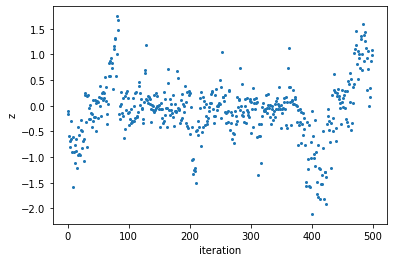

In [12]:
epoch = np.arange(np.size(z1_posterior_tracker[:,0]))
plt.scatter(epoch,z1_posterior_tracker[:,20],s=4)
plt.xlabel('iteration')
plt.ylabel('z')
plt.show()

In [158]:
epoch

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [31]:
for name,params in model.named_parameters():
    g11_tensor = model.g11
    g22_tensor = model.g22
    #break
#x.size()    
#model.named_parameters()

In [33]:
g11_tensor.size()

torch.Size([32, 16])

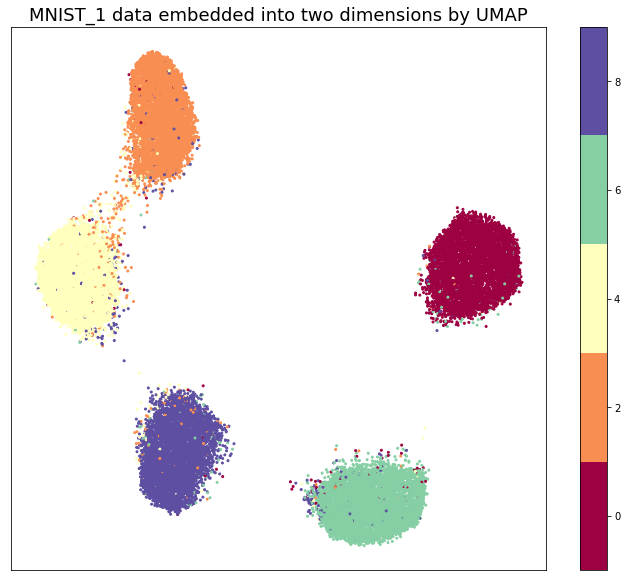

In [9]:
reducer   = umap.UMAP()
data      = latent_repMNIST_1   ## stores posterior samples (10000x32 datapoints)
color     = label_mnist_1/2       ## stores corresponding labels (10000, labels)
embedding = reducer.fit_transform(data)
fig, ax   = plt.subplots(1,figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar      = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(['0','2','4','6','8'])
plt.title("MNIST_1 data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()    

In [29]:
target = np.hstack([label_mnist_1])


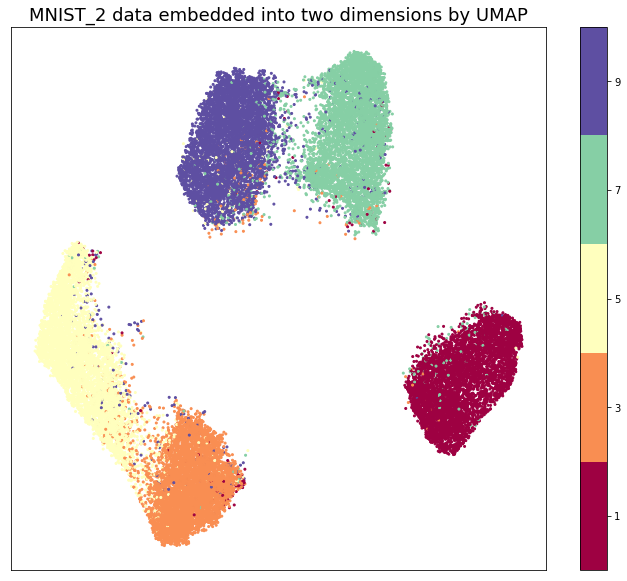

In [32]:
reducer   = umap.UMAP()
data      = latent_repMNIST_2   ## stores posterior samples (10000x32 datapoints)
color     = (label_mnist_2-1)/2       ## stores corresponding labels (10000, labels)
embedding = reducer.fit_transform(data)
fig, ax   = plt.subplots(1,figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar      = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(['1','3','5','7','9'])
plt.title("MNIST_2 data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()    

In [31]:
np.sum(label_mnist_2==10)

0

In [33]:
latent_both= np.concatenate((latent_repMNIST_1, latent_repMNIST_2), axis=1)

np.shape(latent_both)

(29440, 48)

In [19]:
np.shape(label_mnist_1)

(29440,)

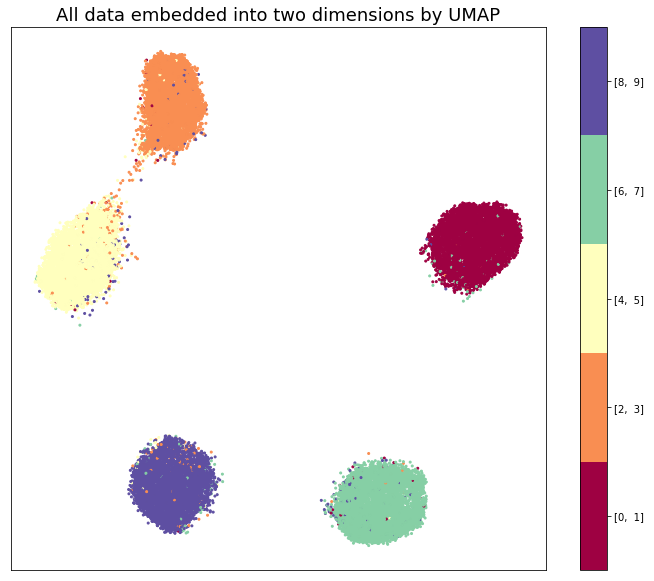

In [37]:
reducer   = umap.UMAP()
data      = latent_both                                     #(29440, 48)
color     = label_mnist_1/2                                 #(29440,   )
labels_1  = label_mnist_1.reshape((len(label_mnist_1),1))   #(29440, 1 )
labels_2  = label_mnist_2.reshape((len(label_mnist_2),1))   #(29440, 1 )
labels    = np.concatenate((labels_1,labels_2),axis=1)      #(29440, 2 )
embedding = reducer.fit_transform(data)
fig, ax   = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar      = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(["[0,  1]", "[2,  3]", "[4,  5] ", "[6,  7]", "[8,  9]"])
plt.title("All data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()

In [71]:
labels

array([[7, 8],
       [4, 5],
       [9, 0],
       ...,
       [4, 5],
       [2, 3],
       [9, 0]])

In [39]:
joint_dataset_train_loader.dataset.mnist_targets_1.numpy()

array([5, 0, 4, ..., 5, 6, 8])

In [40]:
joint_dataset_train_loader.dataset.mnist_targets_2.numpy()

array([5, 0, 4, ..., 5, 6, 8])

In [46]:
for i,joint_data in enumerate(joint_dataset_train_loader):
            data1   = joint_data[0]
            data1   = data1.float()
            data2   = joint_data[1]
            data2   = data2.float()
            data1   = data1.to(device)
            data2   = data2.to(device)
            data1   = data1.view(data1.size(0), -1)
            data2   = data2.view(data2.size(0), -1)
            label1  = joint_data[2]
            label2  = joint_data[3]

In [44]:
torch.sum(data1)

tensor(13080.7891, device='cuda:0')

In [45]:
torch.sum(data2)

tensor(14049.2793, device='cuda:0')

In [47]:
label1

tensor([3, 2, 9, 7, 1, 3, 3, 1, 2, 4, 0, 9, 7, 5, 0, 0, 9, 1, 2, 6, 8, 0, 2, 9,
        6, 5, 5, 3, 7, 8, 2, 6, 6, 4, 5, 0, 6, 6, 9, 0, 9, 0, 9, 5, 0, 0, 0, 8,
        7, 8, 7, 9, 1, 9, 2, 3, 3, 7, 6, 1, 0, 6, 9, 5, 0, 5, 7, 1, 3, 9, 3, 4,
        2, 9, 7, 8, 4, 9, 1, 9, 9, 4, 8, 8, 3, 9, 7, 3, 3, 7, 6, 9, 7, 8, 2, 6,
        5, 4, 1, 9, 7, 5, 8, 3, 6, 1, 6, 8, 4, 9, 1, 1, 9, 6, 1, 3, 4, 5, 1, 9,
        4, 8, 6, 8, 1, 4, 8, 4])

In [48]:
label2

tensor([4, 3, 0, 8, 2, 4, 4, 2, 3, 5, 1, 0, 8, 6, 1, 1, 0, 2, 3, 7, 9, 1, 3, 0,
        7, 6, 6, 4, 8, 9, 3, 7, 7, 5, 6, 1, 7, 7, 0, 1, 0, 1, 0, 6, 1, 1, 1, 9,
        8, 9, 8, 0, 2, 0, 3, 4, 4, 8, 7, 2, 1, 7, 0, 6, 1, 6, 8, 2, 4, 0, 4, 5,
        3, 0, 8, 9, 5, 0, 2, 0, 0, 5, 9, 9, 4, 0, 8, 4, 4, 8, 7, 0, 8, 9, 3, 7,
        6, 5, 2, 0, 8, 6, 9, 4, 7, 2, 7, 9, 5, 0, 2, 2, 0, 7, 2, 4, 5, 6, 2, 0,
        5, 9, 7, 9, 2, 5, 9, 5])